In [1]:
import math
import io
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_msssim import ssim

from typing import List
from masks import ring_mask, box_mask, dot_mask
from load_compression_models import my_bmshj2018_factorized

### Load the Compression Networks

In [2]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda' 
elif torch.backends.mps.is_available():
    'mps'
net = my_bmshj2018_factorized(quality=2, pretrained=True).train().to(device)
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

Parameters: 2998147


### Load the Dataset

In [3]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Load the CelebA dataset
dataset = datasets.CelebA(root='./data', split='train', transform=transform, download=True)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

Files already downloaded and verified


### Run Attack

In [4]:
x = dataset[351][0].unsqueeze(0).to(device)
x_hat = dataset[3183][0].unsqueeze(0).to(device)
x_orig = x_hat.clone()
x_hat.requires_grad = True

In [5]:
# Define the loss function
def loss_fn(
        x_emb: torch.Tensor,
        y_emb: torch.Tensor, 
        x_img: torch.Tensor, 
        y_img: torch.Tensor, 
        lamb: float = 0.3
    ) -> float:
    embedding_loss = F.mse_loss(x_emb, y_emb)
    image_loss =  F.mse_loss(x_img, y_img)
    quality_loss = 1 - ssim(x_img, y_img, data_range=1, size_average=True)
    return embedding_loss + lamb * (image_loss + quality_loss)

In [6]:
def pgd(
        src_img: torch.Tensor, 
        target_img: torch.Tensor, 
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        scheduler: torch.optim.lr_scheduler.LRScheduler, 
        num_steps: int, 
        mask: torch.Tensor = None
    ) -> List:
    # Get the embedding of the source image and make a copy of the target
    src_emb = model.forward(src_img)['y_hat']
    target_baseline = target_img.clone()
    
    # Track the best performance
    best_img = None
    min_loss = float('inf')
    loss_tracker = []

    pbar = tqdm(range(num_steps))
    for _ in pbar:  
        out = model.forward(target_img)
        target_emb = out['y_hat']
        loss = loss_fn(src_emb, target_emb, src_img, target_baseline, lamb=0.0)
        pbar.set_description(f"[Running attack]: Loss {loss.item():.5f}")

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        if mask is not None:
            target_img.grad = target_img.grad * mask
        optimizer.step()
        scheduler.step()
        loss_tracker.append(loss.item())

        # Save the image that achieved the best performance
        if loss.item() < min_loss:
            min_loss = loss
            best_img = target_img

    return best_img, loss_tracker

In [7]:
# Set hyperparams for mask generation and PGD itself
mask_type = 'dot'
if mask_type == 'box':
    num_steps = 1000
    lr = 3e-3
    mask = box_mask()
elif mask_type == 'ring':
    num_steps = 1000
    lr = 3e-3
    num_rings = 50
    ring_width = 1
    ring_separation = 5
    mask = ring_mask(x_hat, num_rings=num_rings, ring_width=ring_width, ring_separation=ring_separation)
elif mask_type == 'dot':
    num_steps = 1000
    lr = 3e-2
    vertical_skip = 3
    horizontal_skip = 3
    mask = dot_mask(x_hat, vertical_skip=vertical_skip, horizontal_skip=horizontal_skip)

# Run the attack and produce an adversarial image y_hat
optimizer = torch.optim.Adam([x_hat], lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
y_hat, loss_tracker = pgd(x, x_hat, model=net, optimizer=optimizer, scheduler=scheduler, num_steps=num_steps, mask=mask)
# Pass the adv image through the compression network and see the result
output = net.forward(y_hat)['x_hat']

[Running attack]: Loss 0.41184: 100%|██████████| 1000/1000 [02:26<00:00,  6.83it/s]


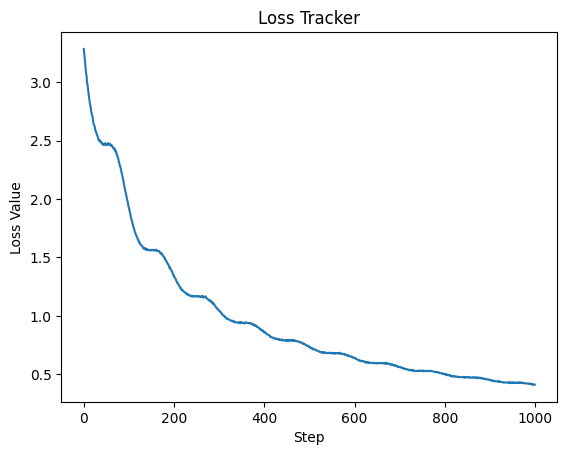

In [8]:
# Show how the loss changed during optimization
plt.plot(loss_tracker)
plt.xlabel('Step')
plt.ylabel('Loss Value')
plt.title('Loss Tracker')
plt.show()

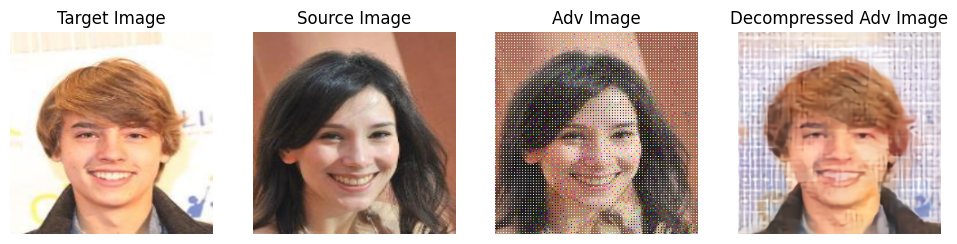

In [9]:
images = [x, x_orig, y_hat, output]
labels = ['Target Image', 'Source Image', 'Adv Image', 'Decompressed Adv Image']

# Create a figure to hold the subplots
fig, axs = plt.subplots(1, 4, figsize=(12, 3))  # 1 row, 4 columns

# Iterate over the images and axes to plot each image
for i, ax in enumerate(axs):
    img = images[i].clip(0, 1).squeeze(0).permute(1, 2, 0).detach().numpy()  # Change the shape to [H, W, C]
    ax.imshow(img)
    ax.set_title(labels[i])
    ax.axis('off')  # Hide axis

plt.show()